# Fine-tuning and deploying a BERTopic model on SageMaker with your own scripts and dataset, by extending existing PyTorch containers


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

---


### INFO: this notebook follows and extends the structure of the [Extending our PyTorch containers example](https://github.com/aws/amazon-sagemaker-examples/blob/main/advanced_functionality/pytorch_extending_our_containers/pytorch_extending_our_containers.ipynb)

With Amazon SageMaker, you can package your own algorithms that can then be trained and deployed in the SageMaker environment. This notebook guides you through an example on how to extend one of our existing and predefined SageMaker deep learning framework containers.

By packaging an algorithm in a container, you can bring almost any code to the Amazon SageMaker environment, regardless of programming language, environment, framework, or dependencies. 

1. [Extending our PyTorch containers](#Extending-our-PyTorch-containers)
    1. [When should I extend a SageMaker container?](#When-should-I-extend-a-SageMaker-container?)
    1. [Permissions](#Permissions)
    1. [This example](#This-example)
    1. [This notebook's structure](#This-notebook's-structure)
1. [Part 1: Docker containers and their use in Amazon SageMaker](#Part-1:-Docker-containers-and-their-use-in-Amazon-SageMaker)
    1. [An overview of Docker](#An-overview-of-Docker)
    1. [How Amazon SageMaker runs your Docker container](#How-Amazon-SageMaker-runs-your-Docker-container)
      1. [Running your container during training](#Running-your-container-during-training)
        1. [The input](#The-input)
        1. [The output](#The-output)
      1. [Running your container during hosting](#Running-your-container-during-hosting)
    1. [Custom files available to build the container used in this example](#Custom-files-available-to-build-the-container-used-in-this-example)
1. [Part 2: Packaging and Uploading your Algorithm for training](#Part-2:-Packaging-and-Uploading-your-Algorithm-for-training)
    1. [The training Dockerfile](#The-training-Dockerfile)
    1. [Writing the training script (bert-topic.py)](#Writing-the-training-script-(bert-topic.py))
    1. [Building and registering the training container](#Building-and-registering-the-training-container)
    1. [Testing your algorithm](#Testing-your-algorithm)
        1. [Download the 20 Newsgroups training dataset](#Download-the-20-Newsgroups-training-dataset)
        1. [SageMaker Python SDK Local Training](#SageMaker-Python-SDK-Local-Training)
        1. [Check the local SageMaker setup](#Check-the-local-SageMaker-setup)
    1. [Fit (+ Deploy, Predict)](#Fit-(+-Deploy,-Predict))
        1. [Local training: Fit](#Local-training:-Fit)
        1. [A sleek alternative to "Bring your own container": bring your own requirements.txt](#A-sleek-alternative-to-"Bring-your-own-container":-bring-your-own-requirements.txt)
    1.[Training your Algorithm in Amazon SageMaker in batch mode](#Training-your-Algorithm-in-Amazon-SageMaker-in-batch-mode)
        1. [Set up the environment](#Set-up-the-environment)
        1. [Create the session](#Create-the-session)
        1. [Upload the data for training](#Upload-the-data-for-training)
        1. [Training on SageMaker in batch mode](#Training-on-SageMaker-in-batch-mode)
1. [Part 3: Packaging and Uploading your Algorithm for inference](#Part-3:-Packaging-and-Uploading-your-Algorithm-for-inference)
    1. [The inference Dockerfile](#The-inference-Dockerfile)
    1. [Writing your own inference script (bert-topic-inference.py)](#Writing-your-own-inference-script-(bert-topic-inference.py))
    1. [Inference from Containerized SageMaker Model)](#Inference-from-Containerized-SageMaker-Model)
        1. [Prepare session to run container locally](#Prepare-session-to-run-container-locally)
        1. [Check for locally running Docker containers (and stop them if needed)](#Check-for-locally-running-Docker-containers-(and-stop-them-if-needed))
        1. [Deploy container locally to create a local endpoint](#Deploy-container-locally-to-create-a-local-endpoint)
        1. [Invoke locally deployed endpoint](#Invoke-locally-deployed-endpoint)
        1. [A sleek alternative to "Bring your own container": bring your own requirements.txt](#A-sleek-alternative-to-"Bring-your-own-container":-bring-your-own-requirements.txt)
        1. [Invoke locally deployed endpoint](#A-sleek-alternative-to-"Bring-your-own-container":-bring-your-own-requirements.txt)
    1. [Deploy container remotely to create a managed Amazon SageMaker endpoint for real-time inference](#Deploy-container-remotely-to-create-a-managed-Amazon-SageMaker-endpoint-for-real-time-inference)
        1. [Invoke remotely deployed endpoint](#Invoke-remotely-deployed-endpoint)
    1. [Optional cleanup](#Optional-cleanup)  
1. [Reference](#Reference)



## Extending our PyTorch containers

### When should I extend a SageMaker container?

You may not need to create a container to bring your own code to Amazon SageMaker. When you are using a framework such as [TensorFlow](https://github.com/aws/sagemaker-tensorflow-container), [MXNet](https://github.com/aws/sagemaker-mxnet-container), [PyTorch](https://github.com/aws/sagemaker-pytorch-container) or [Chainer](https://github.com/aws/sagemaker-chainer-container) that has direct support in SageMaker, you can simply supply the Python code that implements your algorithm using the SDK entry points for that framework.

Even if there is direct SDK support for your environment or framework, you may want to add additional functionality or configure your container environment differently while utilizing our container to use on SageMaker.

**Some of the reasons to extend a SageMaker deep learning framework container are:**
1. Install additional dependencies. (E.g. I want to install a specific Python library, that the current SageMaker containers don't install.)
2. Configure your environment. (E.g. I want to add an environment variable to my container.)

**Although it is possible to extend any of our framework containers as a parent image, the example this notebook covers is currently only intended to work with our PyTorch container.**

This walkthrough shows that it is quite straightforward to extend one of our containers to build your own custom container for PyTorch.

### Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because it creates new repositories in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

### This example

In this example we show how to package a PyTorch container, extending the SageMaker PyTorch container, with a Python example which works with the BERTopic model and the 20 Newsgroups dataset. BERTopic comes now as standalone library and requires GPU support, so the most effective way to use it is to extend the SageMaker PyTorch container, to utilize the existing training and hosting solution made to work on SageMaker. By comparison, if one were to build their own custom framework container from scratch, they would need to implement a training and hosting solution in order to use SageMaker. Here is an example showing [how to create a SageMaker TensorFlow container from scratch](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/tensorflow_bring_your_own/tensorflow_bring_your_own.ipynb).

In this example, we need to use separate base images to support training and hosting, as they are provided separately for [PyTorch](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#sagemaker-framework-containers-sm-support-only). Sometimes you may want to use the same image for training and hosting because they have the same requirements. This simplifies the procedure because we only need to manage one image for both tasks. In that case, merge the parts discussed below into the same Dockerfiles and build one image. Choosing whether to use a single image or two images is a matter of what is most convenient for you to develop and manage.

If you're only using Amazon SageMaker for training or hosting, but not both, only the functionality used needs to be built into your container.
Finally, when using different containers, make sure that the libraries and their versions match, otherwise this could create problems. In fact, some libraries versions are different in the PyTorch training and inference containers.

### This notebook's structure

This notebook is divided into three parts: 
1. Docker containers and their use in Amazon SageMaker
2. _building_ and _using_ the training container 
3. _building_ and _using_ the inference container 

## Part 1: Docker containers and their use in Amazon SageMaker

### An overview of Docker

If you're familiar with Docker already, you can skip ahead to the next section.

For many data scientists, Docker containers are a new technology. But they are not difficult and can significantly simplify the deployment of your software packages. 

Docker provides a simple way to package arbitrary code into an _image_ that is totally self-contained. Once you have an image, you can use Docker to run a _container_ based on that image. Running a container is just like running a program on the machine except that the container creates a fully self-contained environment for the program to run. Containers are isolated from each other and from the host environment, so the way your program is set up is the way it runs, no matter where you run it.

Docker is more powerful than environment managers like Conda or virtualenv because (a) it is completely language independent and (b) it comprises your whole operating environment, including startup commands, and environment variable.

A Docker container is like a virtual machine, but it is much lighter weight. For example, a program running in a container can start in less than a second and many containers can run simultaneously on the same physical or virtual machine instance.

Docker uses a simple file called a `Dockerfile` to specify how the image is assembled. An example is provided below. You can build your Docker images based on Docker images built by yourself or by others, which can simplify things quite a bit.

Docker has become very popular in programming and DevOps communities due to its flexibility and its well-defined specification of how code can be run in its containers. It is the underpinning of many services built in the past few years, such as [Amazon ECS].

Amazon SageMaker uses Docker to allow users to train and deploy arbitrary algorithms.

In Amazon SageMaker, Docker containers are invoked in a one way for training and another, slightly different, way for hosting. The following sections outline how to build containers for the SageMaker environment.

Some helpful links:

* [Docker home page](http://www.docker.com)
* [Getting started with Docker](https://docs.docker.com/get-started/)
* [Dockerfile reference](https://docs.docker.com/engine/reference/builder/)
* [`docker run` reference](https://docs.docker.com/engine/reference/run/)

[Amazon ECS]: https://aws.amazon.com/ecs/

### How Amazon SageMaker runs your Docker container

* Typically you specify a program (e.g. script) as an `ENTRYPOINT` in the Dockerfile, that program will be run at startup and decide what to do. The original `ENTRYPOINT` specified within the SageMaker PyTorch is [here](https://github.com/aws/deep-learning-containers/blob/master/pytorch/training/docker/1.5.1/py3/Dockerfile.cpu#L142).

#### Running your container during training

Currently, our SageMaker PyTorch container utilizes [console_scripts](http://python-packaging.readthedocs.io/en/latest/command-line-scripts.html#the-console-scripts-entry-point) to make use of the `train` command issued at training time. The line that gets invoked during `train` is defined within the setup.py file inside [SageMaker Containers](https://github.com/aws/sagemaker-containers/blob/master/setup.py#L48), our common SageMaker deep learning container framework. When this command is run, it will invoke the [trainer class](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/cli/train.py) to run, which will finally invoke our [PyTorch container code](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/training.py) to run your Python file.

A number of files are laid out for your use, under the `/opt/ml` directory:

    /opt/ml
    |-- input
    |   |-- config
    |   |   |-- hyperparameters.json
    |   |   `-- resourceConfig.json
    |   `-- data
    |       `-- <channel_name>
    |           `-- <input data>
    |-- model
    |   `-- <model files>
    `-- output
        `-- failure

##### The input

* `/opt/ml/input/config` contains information to control how your program runs. `hyperparameters.json` is a JSON-formatted dictionary of hyperparameter names to values. These values are always strings, so you may need to convert them. `resourceConfig.json` is a JSON-formatted file that describes the network layout used for distributed training.
* `/opt/ml/input/data/<channel_name>/` (for File mode) contains the input data for that channel. The channels are created based on the call to CreateTrainingJob, but it's generally important that channels match algorithm expectations. The files for each channel are copied from S3 to this directory, preserving the tree structure indicated by the S3 key structure. 
* `/opt/ml/input/data/<channel_name>_<epoch_number>` (for Pipe mode) is the pipe for a given epoch. Epochs start at zero and go up by one each time you read them. There is no limit to the number of epochs that you can run, but you must close each pipe before reading the next epoch.

##### The output

* `/opt/ml/model/` is the directory where you write the model that your algorithm generates. Your model can be in any format that you want. It can be a single file or a whole directory tree. SageMaker packages any files in this directory into a compressed tar archive file. This file is made available at the S3 location returned in the `DescribeTrainingJob` result.
* `/opt/ml/output` is a directory where the algorithm can write a file `failure` that describes why the job failed. The contents of this file are returned in the `FailureReason` field of the `DescribeTrainingJob` result. For jobs that succeed, there is no reason to write this file as it is ignored.

#### Running your container during hosting

Hosting has a very different model than training because hosting is responding to inference requests that come in via HTTP. Currently, the SageMaker PyTorch containers [uses](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103) our [recommended Python serving stack](https://github.com/aws/sagemaker-containers/blob/master/src/sagemaker_containers/_server.py#L44) to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

Amazon SageMaker uses two URLs in the container:

* `/ping` receives `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these are passed in as well. 

The container has the model files in the same place that they were written to during training:

    /opt/ml
    `-- model
        `-- <model files>



### Custom files available to build the container used in this example

The `container` directory has all the components you need to extend the SageMaker PyTorch container to use as a sample algorithm:

    .
    |-- Dockerfile
    |-- Dockerfile-inference
    `-- bert-topic
        `-- bert-topic.py
        `-- bert-topic-inference.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image for *training*. More details are provided below.
* __`Dockerfile-inference`__ describes how to build your Docker container image for *inference*. More details are provided below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`bert-topic`__ is the directory which contains our user code to be invoked.

In this application, we install and/or update a few libraries, and copy one script in the container, which will be used as `ENTRYPOINT`. You may only need that many, but if you have many supporting routines, you may wish to install more and use more files.

The files that we put in the container are:

* __`bert-topic.py`__ is the program that implements our training algorithm (used only for training container)
* __`bert-topic-inference.py`__ is the program that handles loading our model for inferences (used only for inference container)

## Part 2: Packaging and Uploading your Algorithm for training

### The training Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

We start from the SageMaker PyTorch image as the base. The base image is an ECR image, so it will have the following pattern.
* {account}.dkr.ecr.{region}.amazonaws.com/sagemaker-{framework}:{framework_version}-{processor_type}-{python_version}

Here is an explanation of each field.
1. account - AWS account ID the ECR image belongs to. Our public deep learning framework images are all under the 763104351884 account.
2. region - The region the ECR image belongs to. [Available regions](https://aws.amazon.com/about-aws/global-infrastructure/regional-product-services/).
3. framework - The deep learning framework.
4. framework_version - The version of the deep learning framework.
5. processor_type - CPU or GPU.
6. python_version - The supported version of Python.

So the SageMaker PyTorch ECR image would be:
* 763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-training:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker

Information on supported frameworks and versions can be found in this [README](https://github.com/aws/sagemaker-python-sdk).

Next, we install the required additional libraries like BERTopic and add the code that implements our specific algorithm to the container, and set up the right environment for it to run under.

Finally, we need to specify two environment variables.
1. SAGEMAKER_SUBMIT_DIRECTORY - the directory within the container containing our Python script for training and inference.
2. SAGEMAKER_PROGRAM - the Python script that should be invoked for training and inference.

Let's look at the Dockerfile for this example.

In [ ]:
!cat container/Dockerfile

### Writing the training script (bert-topic.py)

To fine-tune a BERTopic model with a custom dataset on Amazon SageMaker, we will write a training script to be used by the Amazon SageMaker Training Job (or locally).

The training script will need to do the following steps:
- Load a pretrained Model
- Load the dataset
- Define the Training Arguments
- Define a Trainer
- Train the model and save the checkpoint on the validation set

These steps will be done in a `_train()` function.

The script also uses some hyperparameters, which can be extended depending on what is needed for each model. Here we used `language` to choose the training language.

In [ ]:
!pygmentize container/bert-topic/bert-topic.py

### Building and registering the training container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this is the region where the notebook instance was created). If the repository doesn't exist, the script will create it. In addition, since we are using the SageMaker PyTorch image as the base, we will need to retrieve ECR credentials to pull this public image.

Note that your notebook role needs to have the permission to push images to the ECR registry.

In [48]:
# The name of our algorithm -- i.e. the name of the produced training container
training_algorithm_name = "bert-topic-training-example"

In [ ]:
# building and pushing the container
! cd container && sh build_and_push.sh {training_algorithm_name}

In [ ]:
# An alternative and simplified command which outsources the docker build process to codebuild.
# This is especially useful when using Sagemaker studio notebooks where docker is not running.
# Details in https://aws.amazon.com/blogs/machine-learning/using-the-amazon-sagemaker-studio-image-build-cli-to-build-container-images-from-your-studio-notebooks/
#!cd container && sm-docker build {training_algorithm_name}

### Testing your algorithm

When you're packaging your first algorithm to use with Amazon SageMaker, you probably want to test it yourself to make sure it's working correctly. We use the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk) to test both locally and on SageMaker. For more examples with the SageMaker Python SDK, see [Amazon SageMaker Examples](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker-python-sdk). In order to test our algorithm, we need our dataset.

#### Download the 20 Newsgroups training dataset
We will be utilizing the 20 Newsgroups dataset loader provided within AWS to download and load our data for training.

In [ ]:
import os

training_file_name = "training_file.txt"
working_dir = os.getcwd()
training_file_path = os.path.join(working_dir, training_file_name)

print(f"Working Dir: {working_dir}")
print(f"Training File: {training_file_path}")
docs = []

In [ ]:
# data from AWS internal repository, external repo can be used as alternative, see below
import boto3

s3 = boto3.client("s3")
s3.download_file(
    f"sagemaker-example-files-prod-{boto3.session.Session().region_name}",
    "datasets/text/20_newsgroups/20_newsgroups.tar.gz",
    training_file_path.replace(".txt", "_temp.tar.gz"),
)

In [ ]:
# extract few files from the rec.autos topic, without untarring the whole file. No pre-processing is applied
import tarfile
import codecs
import gzip

tar = tarfile.open(training_file_path.replace(".txt", "_temp.tar.gz"), encoding="utf-8")
utf8reader = codecs.getreader("utf-8")
for i, name in enumerate(tar.getmembers()):
    if "rec.autos" in name.name:
        f = tar.extractfile(name)
        if f is not None:
            content = f.read()
            docs = docs + [content.decode("utf-8").split("Message-ID:")[1]]
        if len(docs) > 100:
            break

In [ ]:
# # data from external repository, pre-processing is already applied
# from sklearn.datasets import fetch_20newsgroups

# docs = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))["data"]
# # only use 100 documents out of 18846 for faster iteration
# docs = docs[:100]

In [ ]:
len(docs)

In [ ]:
print("The first document contains the following text:\n\n", docs[1])

In [ ]:
# write the list to a file to be easily passed to the training job

with open(training_file_path, "w") as f:
    for line in docs:
        f.write(
            line.replace("\n", "\\n") + "\n"
        )  # preserve newlines symbols (\n) and write one document per line

#### SageMaker Python SDK Local Training
To represent our training, we use the Estimator class, which needs to be configured in five steps. 
1. IAM role - our AWS execution role ---> make sure to add the "AmazonEC2ContainerRegistryFullAccess" policy to the execution role, otherwise the image push will fail
2. train_instance_count - number of instances to use for training.
3. train_instance_type - type of instance to use for training. For training locally, we specify `local` or `local_gpu`.
4. image_name - our custom PyTorch Docker image we created.
5. hyperparameters - hyperparameters we want to pass.

Let's start with setting up our IAM role. We make use of a helper function within the Python SDK. This function throws an exception if runs outside a SageMaker notebook instance, as it gets metadata from the notebook instance. If running outside, you must provide an IAM role with proper access stated above in [Permissions](#Permissions).

In [ ]:
from sagemaker import get_execution_role

# role to be used for batch submission
role = get_execution_role()
print("role", role)

#### Check the local SageMaker setup

In [ ]:
# Lets set up our SageMaker notebook instance for local mode.
!/bin/bash ./utils/setup.sh

In [14]:
# CHECK if GPUs are available and set the corresponding "instance_type"
import os
import subprocess

instance_type_local = "local"

# if subprocess.call("nvidia-smi") == 0:
#     ## Set type to GPU if one is present
#     instance_type_local = "local_gpu"

print("Instance type = " + instance_type_local)

Instance type = local


### Fit (+ Deploy, Predict)

Now that the rest of our estimator is configured, we can call `fit()` with the path to our local 20 Newsgroups dataset prefixed with `file://`. This invokes our PyTorch container with 'train' and passes in our hyperparameters and other metadata as json files in /opt/ml/input/config within the container to our program entry point defined in the Dockerfile.

After our training has succeeded, our training algorithm outputs our trained model within the /opt/ml/model directory, which is used to handle predictions.

If the container used for the training is also used for the inference (NOT IN THIS CASE!) we can then conveniently call `deploy()` with an instance_count and instance_type, which is 1 and `local`. This invokes our PyTorch container with 'serve', which setups our container to handle prediction requests as defined [here](https://github.com/aws/sagemaker-pytorch-container/blob/master/src/sagemaker_pytorch_container/serving.py#L103). What is returned is a predictor, which is used to make inferences against our trained model.

After our prediction, we can delete our endpoint.

We recommend always testing and training your training algorithm locally first, as it provides quicker iterations and better debuggability.

#### Local training: Fit

In [ ]:
from sagemaker.estimator import Estimator

# define hyperparameters
hyperparameters = {"language": "english"}

# prepare training job
estimator = Estimator(
    role=role,
    train_instance_count=1,
    train_instance_type=instance_type_local,
    image_uri=training_algorithm_name + ":latest",
    hyperparameters=hyperparameters,
)

# launch training job
print(f"file://{training_file_path}")
estimator.fit(f"file://{training_file_path}")
# estimator

In [ ]:
# check where the fitted model has been stored after fit
estimator.model_data

#### A sleek alternative to "Bring your own container": bring your own requirements.txt

Instead of extending the PyTorch container through a Dockerfile, in many cases we can simply import additional libraries to make our model work. 
In these cases, adding the requirements.txt inside the same folder as the code will install the required dependencies at runtime. 
The source directory must be specified in the `source_dir` argument, and the entry point in the `entry_point` argument, when creating PyTorch estimator. Further documentation [here](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#using-third-party-libraries)

In [ ]:
import boto3

my_session = boto3.session.Session()
my_region = my_session.region_name
my_image_uri = (
    "763104351884.dkr.ecr."
    + my_region
    + ".amazonaws.com/pytorch-training:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker"
)
print(
    "my_image_uri:",
    my_image_uri,
    "\nrole:",
    role,
)
from sagemaker.estimator import Estimator

# define hyperparameters
hyperparameters = {"language": "english"}

# prepare training job
estimator = Estimator(
    role=role,
    train_instance_count=1,
    train_instance_type=instance_type_local,
    image_uri=my_image_uri,
    hyperparameters=hyperparameters,
    source_dir="container/bert-topic-byoreq",  # this directory contains the entry point code and the requirements.txt
    entry_point="bert-topic.py",  # this argument is used to override internal container entrypoint, if needed!
)

# launch training job
print(f"file://{training_file_path}")
estimator.fit(f"file://{training_file_path}")

In [ ]:
estimator.model_data

### Training your Algorithm in Amazon SageMaker in batch mode
Once you have your container packaged and/or validated, you can use it to train models in batch mode. Let's do that with the algorithm we made above.

#### Set up the environment
Here we specify the bucket to use (the role has been defined earlier).

In [60]:
import clip
import torch
model, preprocess = clip.load('ViT-B/16', device='cpu')
torch.save((model, preprocess), 'empty/model.pth')

In [ ]:
# S3 prefix
prefix = "DEMO-pytorch-bert-topic"

#### Create the session

The session remembers our connection parameters to SageMaker. We use it to perform all of our SageMaker operations.

In [ ]:
import sagemaker as sage

sess = sage.Session()

#### Upload the data for training

We will use the tools provided by the SageMaker Python SDK to upload the data to a default bucket.

In [ ]:
data_location = sess.upload_data(training_file_path, key_prefix=prefix)
data_location

#### Training on SageMaker in batch mode
Training a model on SageMaker with the Python SDK is done in a way that is similar to the way we trained it locally. This is done by changing our train_instance_type from `local` to one of our [supported EC2 instance types](https://aws.amazon.com/sagemaker/pricing/instance-types/).

In addition, we must now specify the ECR image URL, which we just pushed above.

Finally, our local training dataset has to be in Amazon S3 and the S3 URL to our dataset is passed into the `fit()` call.

Let's first fetch our ECR image url that corresponds to the image we just built and pushed.

Also in this case, whenever useful, one can use the leverage a pre-existing base image with the "bring your own requirements.txt" option (not shown below).

In [ ]:
import boto3

client = boto3.client("sts")
account = client.get_caller_identity()["Account"]

my_session = boto3.session.Session()
region = my_session.region_name

ecr_image = f"{account}.dkr.ecr.{region}.amazonaws.com/{training_algorithm_name}:latest"

print("using ecr_image:", ecr_image)

After training the mode, the output will be packaged into a tarred file `model.tar.gz` and copied to the S3 bucket in use for the training

In [ ]:
from sagemaker.estimator import Estimator

hyperparameters = {"language": "english"}

# instance_type = "ml.g4dn.xlarge"
instance_type = "ml.p2.xlarge"

estimator = Estimator(
    role=role,
    train_instance_count=1,
    train_instance_type=instance_type,
    image_uri=ecr_image,
    hyperparameters=hyperparameters,
)

estimator.fit(data_location)

In [ ]:
# check where the fitted model has been stored after fit
estimator.model_data

In [ ]:
! docker system df
! docker image ls
# remove downloaded docker images to avoid "no space left on device" message
! docker system prune -f
! docker image prune --all --force

## Part 3: Packaging and Uploading your Algorithm for inference

### The inference Dockerfile

Also in this case the Dockerfile describes the image that we want to build. 

We start from the SageMaker PyTorch image as the base, but the *inference* one. 

So the SageMaker PyTorch ECR image in this case would be:
* FROM 763104351884.dkr.ecr.{region}.amazonaws.com/pytorch-inference:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker

Next, we install the required additional libraries (we make sure that to install numba==0.53.1 and nvgpu together with berttopic, otherwise we would get an error!) and add the code that implements our specific algorithm to the container, and set up the right environment for it to run under.

Finally, we need to specify two environment variables.
1. SAGEMAKER_SUBMIT_DIRECTORY - the directory within the container containing our Python script for training and inference.
2. SAGEMAKER_PROGRAM - the Python script that should be invoked for training and inference.

Let's look at the Dockerfile for this example.

In [3]:
from sagemaker import image_uris
image_uris.retrieve(framework='pytorch',region='us-east-1',version='1.8.0',py_version='py3',image_scope='inference', instance_type='ml.g4dn.2xlarge')


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


'763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.8.0-gpu-py3'

In [5]:
# !cat container/Dockerfile-inference

### Writing your own inference script (bert-topic-inference.py)

Given the use of a pre-packaged SageMaker PyTorch container, the only requirement to write an inference script is that it has to define the following template functions:
- `model_fn()` reading the content of an existing model weights directory saved as a `tar.gz` in s3. We will use it to load the trained Model.
- `input_fn()` used here simply to format the data receives from a request made to the endpoint.
- `predict_fn()` calling the output of `model_fn()` to run inference on the output of `input_fn()`.

Optionally a `output_fn()` can be created for inference formatting, using the output of `predict_fn()`. Here it is especially useful since the BERTopic inference output is not really standard, featuring a tuple containing 2 lists.


In [ ]:
!pygmentize container/bert-topic/bert-topic-inference.py

In [1]:
# The name of our algorithm -- i.e. the name of the inference container
inference_algorithm_name = "pytorch-inference-clip-example"

In [55]:
# building and pushing the container
! cd container && sh build_and_push.sh {inference_algorithm_name} Dockerfile-inference

build_and_push.sh: 12: [: pytorch-inference-clip-example: unexpected operator
ECR image fullname: 223890829887.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference-clip-example:latest
WARNING! Your password will be stored unencrypted in /home/ubuntu/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
WARNING! Your password will be stored unencrypted in /home/ubuntu/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (4/4)                                          docker:default
 => [internal] load build definition from Dockerfile-inference             0.0s
 => => transferring dockerfile: 1.99kB                                     0.0s
 => [internal] load

### Inference from Containerized SageMaker Model

In [2]:
import pprint
import boto3

pp = pprint.PrettyPrinter(indent=1)

sm_boto3 = boto3.client("sagemaker")

region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity()["Account"]

image_uri_inference = (
    f"{account_id}.dkr.ecr.{region}.amazonaws.com/{inference_algorithm_name}:latest"
)
image_uri_inference

'223890829887.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference-clip-example:latest'

#### Prepare session to run container locally

In [3]:
import sagemaker
from sagemaker.local import LocalSession
instance_type_local = 'local'
session_local = LocalSession()
session_local.config = {instance_type_local: {"local_code": True}}
print(type(session_local))

from sagemaker import get_execution_role

role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
<class 'sagemaker.local.local_session.LocalSession'>
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


#### Check for locally running Docker containers (and stop them if needed)

In [4]:
! docker ps

CONTAINER ID   IMAGE                                                                                         COMMAND                  CREATED      STATUS      PORTS                                                           NAMES
e4f574d87d5c   docker.artifactory.rbx.com/clip-triton-base-docker:5b975fd60454f0e76a0d2bfd06c2bb489a3ee731   "/opt/nvidia/nvidia_…"   5 days ago   Up 5 days   0.0.0.0:8000-8002->8000-8002/tcp, :::8000-8002->8000-8002/tcp   intelligent_morse


In [5]:
# if model doesn't deploy locally, kill other running containers
# docker stop $(docker ps -a -q)
# docker rm $(docker ps -a -q)

#### Deploy container locally to create a local endpoint 
##### (WARNING: cells stdout will start behaving fuzzy, showing container log info, till the local container is active...)

Disclaimer: if the inference container is missing the default `behavior` is possible to use local files (`source_dir` and `entry_point` arguments)

In [6]:
# import torch
# # torch.tensor([1,2,3,4,5]).save('empty/model.pth')

In [7]:
from sagemaker import Model

# model_data = estimator.model_data

estimator = Model(
    image_uri=image_uri_inference,
    model_data="file://./model.tar.gz",
    role=role,
    source_dir="container/bert-topic",  # this argument is used to override internal container entrypoint, if needed!
    entry_point="bert-topic-inference.py",  # this argument is used to override internal container entrypoint, if needed!
    sagemaker_session=session_local,  # local session
    #                   predictor_cls=None,
    #                   env=None,
    #                   name=None,
    #                   vpc_config=None,
    #                   enable_network_isolation=False,
    #                   model_kms_key=None,
    #                   image_config=None,
    #                   code_location=None,
    #                   container_log_level=20,
    #                   dependencies=None,
    #                   git_config=None
)

predictor = estimator.deploy(1, instance_type_local)

#### Invoke locally deployed endpoint

In [46]:
%%time
import json

sagemaker_session = LocalSession()
sagemaker_session.config = {instance_type_local: {"local_code": True}}

sm_client = sagemaker_session.sagemaker_runtime_client
response = sm_client.invoke_endpoint(
    EndpointName="local-endpoint",
    ContentType="application/json",
    Body=json.dumps({"thumbnail_url": "https://tr.rbxcdn.com/c1b55f2c2d4b72bdf428caf2165ed351/150/150/Hat/Png"}),
)

r = response["Body"]


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:08,960 [INFO ] W-9000-model_1-stdout org.pytorch.serve.wlm.WorkerLifeCycle - serialized_input_data object: {"thumbnail_url": "https://tr.rbxcdn.com/c1b55f2c2d4b72bdf428caf2165ed351/150/150/Hat/Png"}
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:08,960 [INFO ] W-9000-model_1-stdout org.pytorch.serve.wlm.WorkerLifeCycle - input_data object: {'thumbnail_url': 'https://tr.rbxcdn.com/c1b55f2c2d4b72bdf428caf2165ed351/150/150/Hat/Png'}
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:08,960 [INFO ] W-9000-model_1-stdout org.pytorch.serve.wlm.WorkerLifeCycle - Got input Data: {'thumbnail_url': 'https://tr.rbxcdn.com/c1b55f2c2d4b72bdf428caf2165ed351/150/150/Hat/Png'}
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:08,960 [INFO ] W-9000-model_1-stdout org.pytorch.serve.wlm.WorkerLifeCycle - thumbnail_url: https://tr.rbxcdn.com/c1b55f2c2d4b72bdf428caf2165ed351/150/150/Hat/Png
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:09,231 [INFO ] W-9000-model_1-stdout org.pyto

In [47]:
res = r.read().decode()
len(res)
res[0:100]

'No Image Found'

2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:48,457 [INFO ] pool-2-thread-2 TS_METRICS - CPUUtilization.Percent:0.0|#Level:Host|#hostname:6104c552534b,timestamp:1696842108
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:48,457 [INFO ] pool-2-thread-2 TS_METRICS - DiskAvailable.Gigabytes:58.36187744140625|#Level:Host|#hostname:6104c552534b,timestamp:1696842108
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:48,457 [INFO ] pool-2-thread-2 TS_METRICS - DiskUsage.Gigabytes:135.42857360839844|#Level:Host|#hostname:6104c552534b,timestamp:1696842108
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:48,457 [INFO ] pool-2-thread-2 TS_METRICS - DiskUtilization.Percent:69.9|#Level:Host|#hostname:6104c552534b,timestamp:1696842108
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:48,458 [INFO ] pool-2-thread-2 TS_METRICS - MemoryAvailable.Megabytes:200364.4765625|#Level:Host|#hostname:6104c552534b,timestamp:1696842108
2227s001z1-algo-1-ghk5f  | 2023-10-09 09:01:48,458 [INFO ] pool-2-thread-2 TS_METRICS - MemoryUsed.Meg

In [ ]:
%%sh
# check if docker containers are running and kill them if needed
docker ps
docker stop $(docker ps -a -q)
docker rm $(docker ps -a -q)


#### A sleek alternative to "Bring your own container": bring your own requirements.txt

Also in this case, instead of extending the PyTorch container through a Dockerfile, we can simply import additional libraries to make our model work, if needed. 
The process is the same, i.e. adding the requirements.txt inside the same folder as the code will install the required dependencies at runtime. 
The source directory must be specified in the `source_dir` argument, and the entry point in the `entry_point` argument, when creating PyTorch estimator. Further documentation [here](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#using-third-party-libraries)

*CAVEAT*: Installing libraries on the fly through requirements.txt implies additional overhead. This is negligible in case of "always on" single model endpoint deployment, but could have an impact in case of serverless or multi-model deployment. 


In [ ]:
import boto3

my_session = boto3.session.Session()
my_region = my_session.region_name
my_image_uri_inference = (
    "763104351884.dkr.ecr."
    + my_region
    + ".amazonaws.com/pytorch-inference:1.12.1-gpu-py38-cu113-ubuntu20.04-sagemaker"
)
print("my_image_uri_inference:", my_image_uri_inference)
from sagemaker.estimator import Estimator

# define hyperparameters
hyperparameters = {"language": "english"}

estimator = Model(
    image_uri=my_image_uri_inference,
    model_data=model_data,
    role=role,
    source_dir="container/bert-topic-byoreq",  # this directory contains the entrypoint code and the requirements.txt
    entry_point="bert-topic-inference.py",  # this argument is used to override internal container entrypoint, if needed!
    sagemaker_session=session_local,  # local session
    #                   predictor_cls=None,
    #                   env=None,
    #                   name=None,
    #                   vpc_config=None,
    #                   enable_network_isolation=False,
    #                   model_kms_key=None,
    #                   image_config=None,
    #                   code_location=None,
    #                   container_log_level=20,
    #                   dependencies=None,
    #                   git_config=None
)

predictor = estimator.deploy(1, instance_type_local)  #  (ignore the nvgpu errors)

In [ ]:
serverless_config = sagemaker.serverless.serverless_inference_config.ServerlessInferenceConfig(2048, 200, 2)

In [ ]:
# predictor = estimator.deploy(1, instance_type, endpoint_name=endpoint_deployment_name)
predictor = estimator.deploy(endpoint_name=endpoint_deployment_name, serverless_inference_config=serverless_config)

In [80]:
from sagemaker import get_execution_role

role = get_execution_role()
role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


'arn:aws:iam::223890829887:role/aws-reserved/sso.amazonaws.com/AWSReservedSSO_Poweruser_658f486a37df46ae'

#### Invoke locally deployed endpoint

In [87]:
import json

sagemaker_session = LocalSession()
sagemaker_session.config = {instance_type_local: {"local_code": True}}

sm_client = sagemaker_session.sagemaker_runtime_client
response = sm_client.invoke_endpoint(
    EndpointName="local-endpoint",
    ContentType="application/json",
    Body=json.dumps(["Do you like Toyota Corolla?", "I have a Nissan"]),
)

r = response["Body"]
print("RESULT r.read().decode():", r.read().decode())

In [4]:
import pandas as pd
# asset_id_to_img_urls = pd.read_csv('asset_to_image_urls_2.csv')
asset_id_to_img_urls = pd.read_csv('./free_outfits_useroutfit_urls.csv', header=None)
asset_id_to_img_urls.columns = ['asset_id', 'thumbnail_url']

asset_id_to_img_urls.head(2)

,asset_id,thumbnail_url
0,6129202655,https://tr.rbxcdn.com/b67dc99e9ceb0ba7df306daf...
1,7719834093,https://tr.rbxcdn.com/dcba731fcbd8024b9ae97533...


In [5]:
img_urls = asset_id_to_img_urls['thumbnail_url'].tolist()[:500000]
len(img_urls)

500000

In [6]:
endpoint_deployment_name = "clip-test-endpoint2"

In [7]:
import retry
import boto3
import json
import sagemaker as sage

sm_client = sage.Session().sagemaker_runtime_client

# @retry.retry(tries=4, delay=30, jitter=(0, 10))
def invoke_sagemaker_for_url(url):
    try:
        response = sm_client.invoke_endpoint(
            EndpointName=endpoint_deployment_name,
            ContentType="application/json",
            Body=json.dumps({"thumbnail_url": url}),
        )
        r = response["Body"]
        res = r.read().decode()
        return res
    except Exception as e:
        # print(e)
        return None

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ubuntu/.config/sagemaker/config.yaml


In [8]:
img_urls[10]

'https://tr.rbxcdn.com/18b56757b3a9f798e07e037047ac1a89/150/150/Avatar/Png'

In [13]:
invoke_sagemaker_for_url(img_urls[0])

'[[0.7835999727249146, -0.7336000204086304, -0.11800000071525574, -0.1363999992609024, -0.24009999632835388, 0.03449999913573265, 0.03460000082850456, 0.257999986410141, -0.5882999897003174, 0.21199999749660492, 0.22130000591278076, -1.003100037574768, 0.2639999985694885, 0.5130000114440918, 0.1931000053882599, 0.0697999969124794, 0.15919999778270721, -0.056699998676776886, -0.09149999916553497, -0.3271999955177307, 0.211899995803833, 0.14830000698566437, 0.22280000150203705, -0.20020000636577606, 0.06920000165700912, 0.38119998574256897, -0.2596000134944916, 0.4546000063419342, 0.08259999752044678, -0.13680000603199005, 0.09870000183582306, -0.06780000030994415, -0.04580000042915344, -0.4081000089645386, -0.29339998960494995, 0.3968999981880188, -0.041999999433755875, 0.20819999277591705, 0.20170000195503235, -0.2992999851703644, 0.4805000126361847, -0.4138000011444092, 0.4214000105857849, 0.33899998664855957, 0.12929999828338623, -0.3617999851703644, 0.7814000248908997, 0.29390001296

In [17]:
%%time
# print current time in PST
from datetime import datetime
import pytz

tz = pytz.timezone("America/Los_Angeles")
print("start time: ")
print(datetime.now(tz))


from multiprocessing import Pool
import tqdm

with Pool(100) as p:
    results = list(tqdm.tqdm(p.imap(invoke_sagemaker_for_url, img_urls), total=len(img_urls)))

start time: 
2023-10-10 18:16:42.162152-07:00


100%|██████████| 500000/500000 [40:40<00:00, 204.84it/s]  


CPU times: user 1min 41s, sys: 43.9 s, total: 2min 25s
Wall time: 40min 44s


In [14]:
%%time
# print current time in PST
from datetime import datetime
import pytz

tz = pytz.timezone("America/Los_Angeles")
print("start time: ")
print(datetime.now(tz))


from multiprocessing import Pool
import tqdm

with Pool(120) as p:
    results = list(tqdm.tqdm(p.imap(invoke_sagemaker_for_url, img_urls), total=len(img_urls)))

start time: 
2023-10-11 08:31:38.539787-07:00


100%|██████████| 500000/500000 [36:44<00:00, 226.84it/s] 


CPU times: user 1min 50s, sys: 43.3 s, total: 2min 33s
Wall time: 36min 48s


In [15]:
import numpy as np
result_np = np.array(results)
result_np[0:10]

array(['[[0.7835999727249146, -0.7336000204086304, -0.11800000071525574, -0.1363999992609024, -0.24009999632835388, 0.03449999913573265, 0.03460000082850456, 0.257999986410141, -0.5882999897003174, 0.21199999749660492, 0.22130000591278076, -1.003100037574768, 0.2639999985694885, 0.5130000114440918, 0.1931000053882599, 0.0697999969124794, 0.15919999778270721, -0.056699998676776886, -0.09149999916553497, -0.3271999955177307, 0.211899995803833, 0.14830000698566437, 0.22280000150203705, -0.20020000636577606, 0.06920000165700912, 0.38119998574256897, -0.2596000134944916, 0.4546000063419342, 0.08259999752044678, -0.13680000603199005, 0.09870000183582306, -0.06780000030994415, -0.04580000042915344, -0.4081000089645386, -0.29339998960494995, 0.3968999981880188, -0.041999999433755875, 0.20819999277591705, 0.20170000195503235, -0.2992999851703644, 0.4805000126361847, -0.4138000011444092, 0.4214000105857849, 0.33899998664855957, 0.12929999828338623, -0.3617999851703644, 0.7814000248908997, 0.2939

In [10]:
import clip
import torch
import requests
from PIL import Image

model, preprocess = clip.load("ViT-B/16", device="cpu")
# model, preprocess = torch.load('empty/model.pth')



In [19]:
image = preprocess(
                Image.open(requests.get(img_urls[0], stream=True).raw)
            ).unsqueeze(0)
print(image.shape)
with torch.no_grad():
    image_features = model.encode_image(image).numpy()
image_features
np.allclose(image_features, np.array(json.loads(result_np[0])), atol=1e-4)

torch.Size([1, 3, 224, 224])


True

In [57]:
img_urls[0]

'https://tr.rbxcdn.com/b67dc99e9ceb0ba7df306daf1eaca1ed/150/150/Avatar/Png'

In [49]:
np.array(json.loads(result_np[0])).shape,  image_features.shape

((1, 512), (1, 512))

In [35]:
import boto3
from datetime import datetime, timedelta

# Create a Cost Explorer client
client = boto3.client('ce')

# Define the time period to query
now = datetime.utcnow()
end = now.strftime('%Y-%m-%dT%H:%M:%SZ')  # Current time in UTC in ISO format
start = (now - timedelta(hours=56)).strftime('%Y-%m-%dT%H:%M:%SZ')  # 12 hours ago in UTC in ISO format

# Define the query parameters
query = {
    "TimePeriod": {
        "Start": start,
        "End": end
    },
    "Granularity": "HOURLY",
    "Filter": {
        "Dimensions": {
            "Key": "SERVICE",
            "Values": [
                "Amazon SageMaker"
            ]
        }
    },
    "Metrics": ["UnblendedCost"]
}

# Retrieve the cost data
try:
    data = client.get_cost_and_usage(**query)
    # Print out the response
    # print(response)
except client.exceptions.ValidationException as e:
    # Handle the exception
    print(f"An error occurred: {e}")


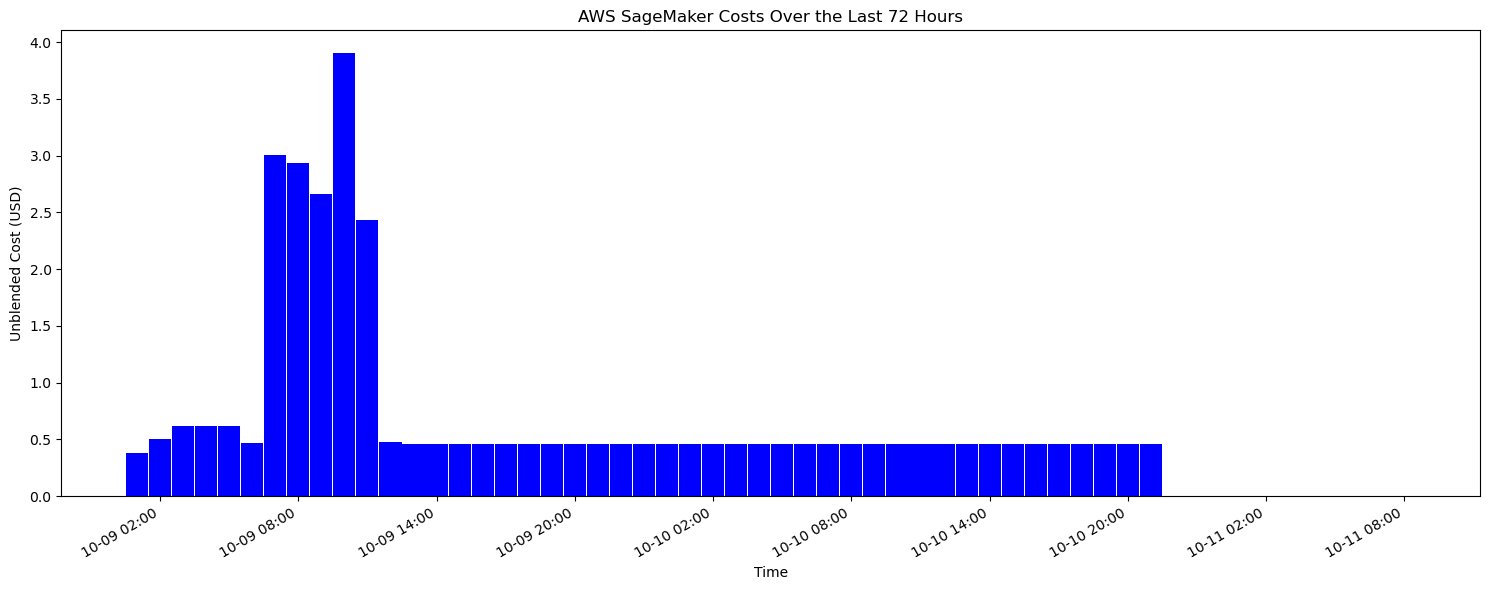

In [36]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
# Extracting necessary data
timestamps = []
costs = []

for item in data['ResultsByTime']:
    start_time = item['TimePeriod']['Start']
    # Converting the time format to datetime object
    timestamp = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%SZ')
    timestamps.append(timestamp)
    costs.append(float(item['Total']['UnblendedCost']['Amount']))

# Creating the bar plot
plt.figure(figsize=(15, 6))
plt.bar(timestamps, costs, color='blue', width=0.04)  # you can adjust the width to your preference
plt.xlabel('Time')
plt.ylabel('Unblended Cost (USD)')
plt.title('AWS SageMaker Costs Over the Last 72 Hours')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # format the timestamps on the x-axis
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))  # place a tick every 6 hours
plt.gcf().autofmt_xdate()  # auto-format the x-axis date labels (e.g., rotate them)
plt.tight_layout()
plt.show()




In [30]:
import time

# Get the current timezone name
current_timezone_name = time.tzname[time.daylight]

print(f"Current timezone: {current_timezone_name}")


Current timezone: UTC


In [68]:
%%time
# print current time in PST
from datetime import datetime
import pytz

tz = pytz.timezone("America/Los_Angeles")
print("start time: ")
print(datetime.now(tz))


from multiprocessing import Pool
import tqdm

with Pool(60) as p:
    results = list(tqdm.tqdm(p.imap(invoke_sagemaker_for_url, img_urls), total=len(img_urls)))

start time: 
2023-10-09 04:48:20.698649-07:00


  0%|          | 0/119578 [00:54<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
%%sh
# check if docker containers are running and kill them if needed
docker ps
docker stop $(docker ps -a -q)
docker rm $(docker ps -a -q)

### Deploy container remotely to create a managed Amazon SageMaker endpoint for real-time inference

In [ ]:
from sagemaker import Model

import sagemaker as sage

sess = sage.Session()

# instance_type = "ml.m5.xlarge" # no GPU, will trigger an error
# instance_type = "ml.g4dn.xlarge"
instance_type = "ml.p2.xlarge"
model_data = estimator.model_data

endpoint_deployment_name = "my-BERTopic-test-endpoint"

estimator = Model(
    image_uri=image_uri_inference,
    model_data=model_data,
    role=role,
    source_dir="container/bert-topic",
    entry_point="bert-topic-inference.py",
    sagemaker_session=sess,  # not local session anymore
    #                   predictor_cls=None,
    #                   env=None,
    #                   name=None,
    #                   vpc_config=None,
    #                   enable_network_isolation=False,
    #                   model_kms_key=None,
    #                   image_config=None,
    #                   code_location=None,
    #                   container_log_level=20,
    #                   dependencies=None,
    #                   git_config=None
)

# deploy the model
predictor = estimator.deploy(1, instance_type, endpoint_name=endpoint_deployment_name)

Manually check the deployed endpoint name, it will have the name 
- my-BERTopic-test-endpoint

#### Invoke remotely deployed endpoint

In [ ]:
sm_client = sess.sagemaker_runtime_client
endpoint_name = "my-BERTopic-test-endpoint"
response = sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Body=json.dumps(["Do you like Toyota Corolla?", "I have a Nissan"]),
)

r = response["Body"]
print("RESULT r.read().decode():", r.read().decode())

### Optional cleanup of the create endpoint
The created endpoint can be deleted with the code below.

This part represent the end of the notebook.

In [ ]:
import boto3

client = boto3.client("sagemaker")
response = client.describe_endpoint_config(EndpointConfigName=endpoint_deployment_name)
model_name = response["ProductionVariants"][0]["ModelName"]
client.delete_endpoint(EndpointName=endpoint_deployment_name)
client.delete_endpoint_config(EndpointConfigName=endpoint_deployment_name)
client.delete_model(ModelName=model_name)

## Reference
- [How Amazon SageMaker interacts with your Docker container for training](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html)
- [How Amazon SageMaker interacts with your Docker container for inference](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html)
- [BERTtopic model](https://maartengr.github.io/BERTopic/index.html)
- [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/)
- [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk)
- [Dockerfile](https://docs.docker.com/engine/reference/builder/)
- [scikit-bring-your-own](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb)
- [SageMaker PyTorch container](https://github.com/aws/sagemaker-pytorch-container)



## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/advanced_functionality|pytorch_extend_container_train_deploy_bertopic|BERTtopic_extending_container.ipynb)
